code taken from here https://mccormickml.com/2020/03/10/question-answering-with-a-fine-tuned-BERT/

## 1. Install huggingface transformers library

In [1]:
!pip install transformers

     |████████████████████████████████| 573kB 7.9MB/s 
     |████████████████████████████████| 890kB 22.3MB/s 
     |████████████████████████████████| 3.7MB 37.2MB/s 
     |████████████████████████████████| 1.0MB 50.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.41-cp36-none-any.whl size=893334 sha256=58c34341c861b95e3b6b6f7b090b395545dd3add33b0703d51f5ad3c001b76c4
  Stored in directory: /root/.cache/pip/wheels/22/5a/d4/b020a81249de7dc63758a34222feaa668dbe8ebfe9170cc9b1
Successfully built sacremoses


In [0]:
import torch

## 2. Load Fine-Tuned BERT-large

For Question Answering we use the `BertForQuestionAnswering` class from the `transformers` library.

This class supports fine-tuning, but for this example we will keep things simpler and load a BERT model that has already been fine-tuned for the SQuAD benchmark.

BERT-large is really big... it has 24-layers and an embedding size of 1,024, for a total of 340M parameters! Altogether it is 1.34GB, so expect it to take a couple minutes to download to your Colab instance. 



In [3]:
from transformers import BertForQuestionAnswering

model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')


Load the tokenizer as well. 


In [4]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

## 3. Ask a Question

Now we're ready to feed in an example!

A QA example consists of a question and a passage of text containing the answer to that question.

Let's try an example using the text in this tutorial!

In [0]:
question = "Why was Tesla returned to Gospic?"
answer_text = "On 24 March 1879, Tesla was returned to Gospic under police guard for not having a residence permit. On 17 April 1879, Milutin Tesla died at the age of 60 after contracting an unspecified illness (although some sources say that he died of a stroke). During that year, Tesla taught a large class of students in his old school, Higher Real Gymnasium, in Gospic."

We'll need to run the BERT tokenizer against both the `question` and the `answer_text`. To feed these into BERT, we actually concatenate them together and place the special [SEP] token in between.


In [6]:
# Apply the tokenizer to the input text, treating them as a text-pair.
input_ids = tokenizer.encode(question, answer_text)

print('The input has a total of {:} tokens.'.format(len(input_ids)))

The input has a total of 92 tokens.


Just to see exactly what the tokenizer is doing, let's print out the tokens with their IDs.

In [7]:
# BERT only needs the token IDs, but for the purpose of inspecting the 
# tokenizer's behavior, let's also get the token strings and display them.
tokens = tokenizer.convert_ids_to_tokens(input_ids)

# For each token and its id...
for token, id in zip(tokens, input_ids):
    
    # If this is the [SEP] token, add some space around it to make it stand out.
    if id == tokenizer.sep_token_id:
        print('')
    
    # Print the token string and its ID in two columns.
    print('{:<12} {:>6,}'.format(token, id))

    if id == tokenizer.sep_token_id:
        print('')
    

[CLS]           101
why           2,339
was           2,001
tesla        26,060
returned      2,513
to            2,000
go            2,175
##sp         13,102
##ic          2,594
?             1,029

[SEP]           102

on            2,006
24            2,484
march         2,233
1879          7,449
,             1,010
tesla        26,060
was           2,001
returned      2,513
to            2,000
go            2,175
##sp         13,102
##ic          2,594
under         2,104
police        2,610
guard         3,457
for           2,005
not           2,025
having        2,383
a             1,037
residence     5,039
permit        9,146
.             1,012
on            2,006
17            2,459
april         2,258
1879          7,449
,             1,010
mil          23,689
##uti        21,823
##n           2,078
tesla        26,060
died          2,351
at            2,012
the           1,996
age           2,287
of            1,997
60            3,438
after         2,044
contracting  21,01

We've concatenated the `question` and `answer_text` together, but BERT still needs a way to distinguish them. BERT has two special "Segment" embeddings, one for segment "A" and one for segment "B". Before the word embeddings go into the BERT layers, the segment A embedding needs to be added to the `question` tokens, and the segment B embedding needs to be added to each of the `answer_text` tokens. 

These additions are handled for us by the `transformer` library, and all we need to do is specify a '0' or '1' for each token. 

Note: In the `transformers` library, huggingface likes to call these `token_type_ids`, but I'm going with `segment_ids` since this seems clearer, and is consistent with the BERT paper.

In [0]:
# Search the input_ids for the first instance of the `[SEP]` token.
sep_index = input_ids.index(tokenizer.sep_token_id)

# The number of segment A tokens includes the [SEP] token istelf.
num_seg_a = sep_index + 1

# The remainder are segment B.
num_seg_b = len(input_ids) - num_seg_a

# Construct the list of 0s and 1s.
segment_ids = [0]*num_seg_a + [1]*num_seg_b

# There should be a segment_id for every input token.
assert len(segment_ids) == len(input_ids)

>*Side Note: Where's the padding?*
>
> The original [example code](https://huggingface.co/transformers/model_doc/bert.html?highlight=bertforquestionanswering#transformers.BertForQuestionAnswering) does not perform any padding. I suspect that this is because we are only feeding in a *single example*. If we instead fed in a batch of examples, then we would need to pad or truncate all of the samples in the batch to a single length, and supply an attention mask to tell BERT to ignore the padding tokens. 

We're ready to feed our example into the model!



In [0]:
# Run our example through the model.
start_scores, end_scores = model(torch.tensor([input_ids]), # The tokens representing our input text.
                                 token_type_ids=torch.tensor([segment_ids])) # The segment IDs to differentiate question from answer_text


Now we can highlight the answer just by looking at the most probable start and end words. 

In [10]:
# Find the tokens with the highest `start` and `end` scores.
answer_start = torch.argmax(start_scores)
answer_end = torch.argmax(end_scores)

# Combine the tokens in the answer and print it out.
answer = ' '.join(tokens[answer_start:answer_end+1])

print('Answer: "' + answer + '"')

Answer: "not having a residence permit"


It got it right! Awesome :)

> *Side Note: It's a little naive to pick the highest scores for start and end--what if it predicts an end word that's before the start word?! The correct implementation is to pick the highest total score for which end >= start.*

With a little more effort, we can reconstruct any words that got broken down into subwords.

In [11]:
# Start with the first token.
answer = tokens[answer_start]

# Select the remaining answer tokens and join them with whitespace.
for i in range(answer_start + 1, answer_end + 1):
    
    # If it's a subword token, then recombine it with the previous token.
    if tokens[i][0:2] == '##':
        answer += tokens[i][2:]
    
    # Otherwise, add a space then the token.
    else:
        answer += ' ' + tokens[i]

print('Answer: "' + answer + '"')

Answer: "not having a residence permit"


## 4. Visualizing Scores

I was curious to see what the scores were for all of the words. The following cells generate bar plots showing the start and end scores for every word in the input.

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
#sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (16,8)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Retrieve all of the start and end scores, and use all of the tokens as x-axis labels.

In [0]:
# Pull the scores out of PyTorch Tensors and convert them to 1D numpy arrays.
s_scores = start_scores.detach().numpy().flatten()
e_scores = end_scores.detach().numpy().flatten()

# We'll use the tokens as the x-axis labels. In order to do that, they all need
# to be unique, so we'll add the token index to the end of each one.
token_labels = []
for (i, token) in enumerate(tokens):
    token_labels.append('{:} - {:>2}'.format(token, i))


Create a bar plot showing the score for every input word being the "start" word.

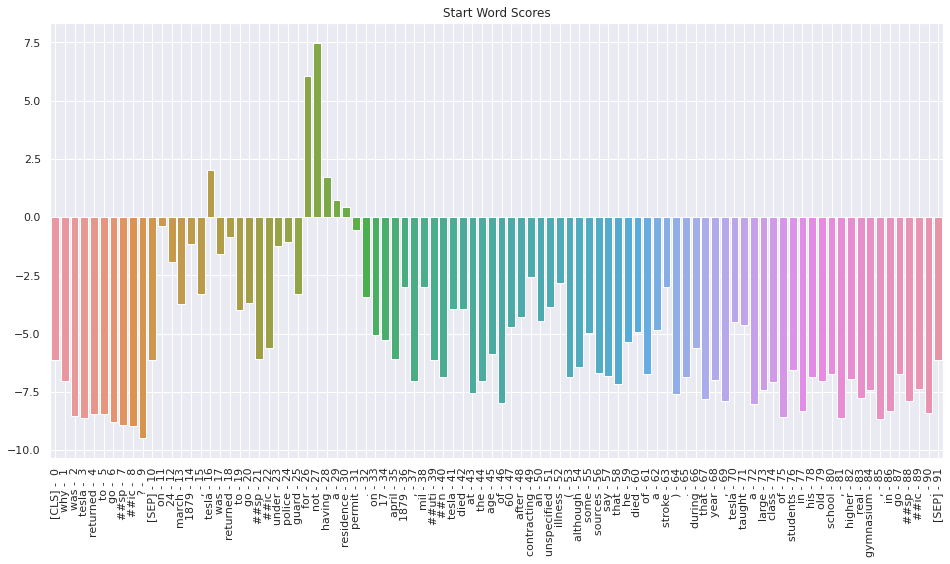

In [14]:
# Create a barplot showing the start word score for all of the tokens.
ax = sns.barplot(x=token_labels, y=s_scores, ci=None)

# Turn the xlabels vertical.
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")

# Turn on the vertical grid to help align words to scores.
ax.grid(True)

plt.title('Start Word Scores')

plt.show()

Create a second bar plot showing the score for every input word being the "end" word.

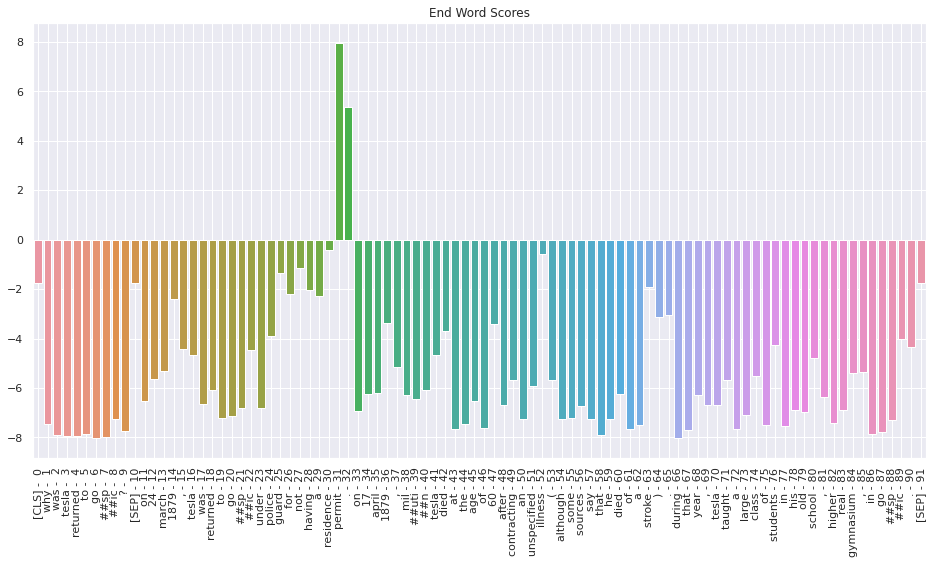

In [15]:
# Create a barplot showing the end word score for all of the tokens.
ax = sns.barplot(x=token_labels, y=e_scores, ci=None)

# Turn the xlabels vertical.
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")

# Turn on the vertical grid to help align words to scores.
ax.grid(True)

plt.title('End Word Scores')

plt.show()

**Alternate View**

I also tried visualizing both the start and end scores on a single bar plot, but I think it may actually be more confusing then seeing them separately. 

In [0]:
import pandas as pd

# Store the tokens and scores in a DataFrame. 
# Each token will have two rows, one for its start score and one for its end
# score. The "marker" column will differentiate them. A little wacky, I know.
scores = []
for (i, token_label) in enumerate(token_labels):

    # Add the token's start score as one row.
    scores.append({'token_label': token_label, 
                   'score': s_scores[i],
                   'marker': 'start'})
    
    # Add  the token's end score as another row.
    scores.append({'token_label': token_label, 
                   'score': e_scores[i],
                   'marker': 'end'})
    
df = pd.DataFrame(scores)


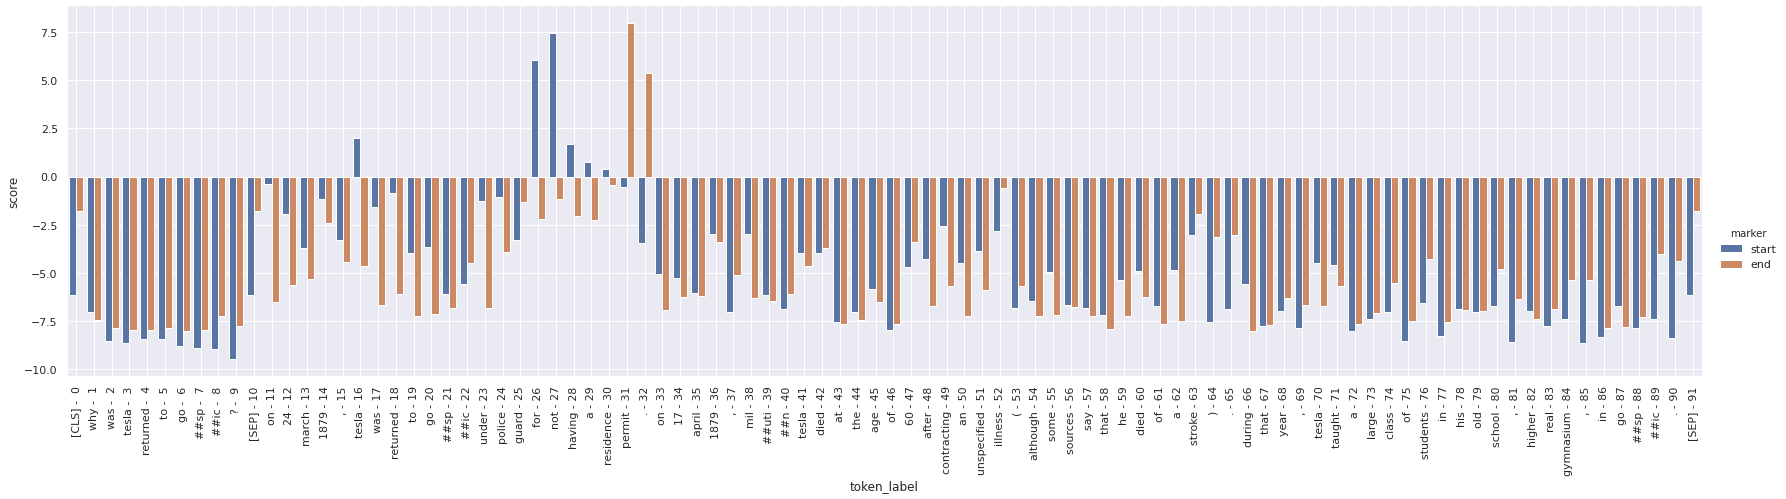

In [17]:
# Draw a grouped barplot to show start and end scores for each word.
# The "hue" parameter is where we tell it which datapoints belong to which
# of the two series.
g = sns.catplot(x="token_label", y="score", hue="marker", data=df,
                kind="bar", height=6, aspect=4)

# Turn the xlabels vertical.
g.set_xticklabels(g.ax.get_xticklabels(), rotation=90, ha="center")

# Turn on the vertical grid to help align words to scores.
g.ax.grid(True)


In [0]:
g.savefig("attention-dist.png")

## 5. More Examples

Turn the QA process into a function so we can easily try out other examples.

In [0]:
def answer_question(question, answer_text):
    '''
    Takes a `question` string and an `answer_text` string (which contains the
    answer), and identifies the words within the `answer_text` that are the
    answer. Prints them out.
    '''
    # ======== Tokenize ========
    # Apply the tokenizer to the input text, treating them as a text-pair.
    input_ids = tokenizer.encode(question, answer_text)

    # Report how long the input sequence is.
    print('Query has {:,} tokens.\n'.format(len(input_ids)))

    # ======== Set Segment IDs ========
    # Search the input_ids for the first instance of the `[SEP]` token.
    sep_index = input_ids.index(tokenizer.sep_token_id)

    # The number of segment A tokens includes the [SEP] token istelf.
    num_seg_a = sep_index + 1

    # The remainder are segment B.
    num_seg_b = len(input_ids) - num_seg_a

    # Construct the list of 0s and 1s.
    segment_ids = [0]*num_seg_a + [1]*num_seg_b

    # There should be a segment_id for every input token.
    assert len(segment_ids) == len(input_ids)

    # ======== Evaluate ========
    # Run our example question through the model.
    start_scores, end_scores = model(torch.tensor([input_ids]), # The tokens representing our input text.
                                    token_type_ids=torch.tensor([segment_ids])) # The segment IDs to differentiate question from answer_text

    # ======== Reconstruct Answer ========
    # Find the tokens with the highest `start` and `end` scores.
    answer_start = torch.argmax(start_scores)
    answer_end = torch.argmax(end_scores)

    # Get the string versions of the input tokens.
    tokens = tokenizer.convert_ids_to_tokens(input_ids)

    # Start with the first token.
    answer = tokens[answer_start]

    # Select the remaining answer tokens and join them with whitespace.
    for i in range(answer_start + 1, answer_end + 1):
        
        # If it's a subword token, then recombine it with the previous token.
        if tokens[i][0:2] == '##':
            answer += tokens[i][2:]
        
        # Otherwise, add a space then the token.
        else:
            answer += ' ' + tokens[i]

    return answer

As our reference text, I've taken the Abstract of the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf).


In [0]:
import json
with open("dev-v1.1.json",mode="rt",encoding="utf-8") as file:
    qa_data = json.load(file)

In [0]:
lookup = 'abcdefghijklmnopqrstuvwxyz1234567890?.,'
# check for valid characters
def in_white_list(_word):
    valid_word = False
    for char in _word:
        if char in lookup:
            valid_word = True
            break

    if valid_word is False:
        return False

    return True

In [0]:
# extract paragraphs,question and answers from SQuAD_data
def get_SQuAD_data(qa_data,max_data_count,max_context_seq_length,max_question_seq_length,max_target_seq_length):
    data = list()
    #print(len(qa_data['data']['qas]))
    for instance in qa_data['data']:
        for paragraph in instance['paragraphs']:
            context = paragraph['context']
            context_wid_list = [w.lower() for w in nltk.word_tokenize(context) if in_white_list(w)]
            if len(context_wid_list) > max_context_seq_length:
                continue
            qas = paragraph['qas']
            for qas_instance in qas:
                question = qas_instance['question']
                question_wid_list = [w.lower() for w in nltk.word_tokenize(question) if in_white_list(w)]
                if len(question_wid_list) > max_question_seq_length:
                    continue
                answers = qas_instance['answers']
                num = qas_instance['id']
                for answer in answers:
                    ans = answer['text']
                    answer_wid_list = [w.lower() for w in nltk.word_tokenize(ans) if in_white_list(w)]
                    if len(answer_wid_list) > max_target_seq_length:
                        continue
                    if len(data) < max_data_count:
                        data.append((context, question, ans,num))

            if len(data) >= max_data_count:
                break

            break
    return data

In [0]:
pip install nltk

In [0]:
import nltk
nltk.download("punkt")
max_data_count = 20000
max_context_seq_length = 400
max_question_seq_length = 50
max_target_seq_length = 100
data = get_SQuAD_data(qa_data,max_data_count,max_context_seq_length,max_question_seq_length,max_target_seq_length)
print("Total Q&A data size",len(data))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
2
Total Q&A data size 1162


In [0]:
answer_question(data[200][1], data[200][0])

Query has 113 tokens.



'bskyb'

In [0]:
x= {}

In [0]:
data[200][3]

'57092322efce8f15003a7db0'

In [0]:
for i in data:
  x.update( {i[3] : answer_question(i[1], i[0])} )

Query has 171 tokens.

Query has 171 tokens.

Query has 171 tokens.

Query has 171 tokens.

Query has 171 tokens.

Query has 171 tokens.

Query has 168 tokens.

Query has 168 tokens.

Query has 168 tokens.

Query has 168 tokens.

Query has 168 tokens.

Query has 168 tokens.

Query has 174 tokens.

Query has 174 tokens.

Query has 174 tokens.

Query has 169 tokens.

Query has 169 tokens.

Query has 169 tokens.

Query has 168 tokens.

Query has 168 tokens.

Query has 168 tokens.

Query has 167 tokens.

Query has 167 tokens.

Query has 167 tokens.

Query has 169 tokens.

Query has 169 tokens.

Query has 169 tokens.

Query has 166 tokens.

Query has 166 tokens.

Query has 166 tokens.

Query has 169 tokens.

Query has 169 tokens.

Query has 169 tokens.

Query has 166 tokens.

Query has 166 tokens.

Query has 166 tokens.

Query has 170 tokens.

Query has 170 tokens.

Query has 170 tokens.

Query has 170 tokens.

Query has 170 tokens.

Query has 170 tokens.

Query has 177 tokens.

Query has 1

In [0]:
with open('predictions.json', 'w', encoding='utf-8') as f:
    json.dump(x, f, ensure_ascii=False, indent=4)